In [23]:
from functools import reduce

import matplotlib.pyplot as plt
import numpy as np
import plotly.graph_objects as go
import polars as pl
import umap
from matplotlib import colormaps
from PIL import Image
from scipy.cluster.hierarchy import (
    ClusterNode,
    dendrogram,
    leaves_list,
    linkage,
    to_tree,
)
from tqdm import tqdm

In [3]:
YOX1 = "YML027W"
YHP1 = "YDR451C"
CLN3 = "YAL040C"

In [4]:
df_data = pl.read_csv(
    "../data/preprocessed_2090_combined_timeseries.csv", null_values=["NA"]
)
genes = np.array(df_data.columns)

In [5]:
df_ccm = pl.read_csv(
    "../data/Cell_Cycle_5690_CCM_all_vs_all.csv", null_values=["NA"]
).drop("")

In [5]:
df_ccm.describe()

statistic,E,tau,tp,nn,lib_column,target_column,lib_size,num_pred,rho,mae,rmse
str,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""count""",3.23761e7,3.23761e7,3.23761e7,3.23761e7,3.23761e7,3.23761e7,3.23761e7,3.23761e7,3.23761e7,3.23761e7,3.23761e7
"""null_count""",0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
"""mean""",5.069069,5.776977,0.0,6.069069,2845.5,2845.5,83.624605,83.624605,0.356712,25.057596,33.039894
"""std""",1.222796,3.030773,0.0,1.222796,1642.561516,1642.561516,15.231628,15.231628,0.302686,194.002362,251.572235
"""min""",1.0,1.0,0.0,2.0,1.0,1.0,58.0,58.0,-0.846923,0.003463,0.009779
"""25%""",4.0,3.0,0.0,5.0,1423.0,1423.0,68.0,68.0,0.137027,1.541237,1.994818
"""50%""",6.0,6.0,0.0,7.0,2846.0,2846.0,84.0,84.0,0.384052,3.274574,4.276332
"""75%""",6.0,8.0,0.0,7.0,4268.0,4268.0,98.0,98.0,0.598184,8.626809,11.355796
"""max""",6.0,10.0,0.0,7.0,5690.0,5690.0,108.0,108.0,0.999489,19294.404344,23647.435896


In [6]:
df_ccm.head()

E,tau,tp,nn,lib_column,target_column,lib_size,num_pred,rho,mae,rmse
i64,i64,i64,i64,i64,i64,i64,i64,f64,f64,f64
4,3,0,5,1,1,99,99,0.939771,2.248597,3.228245
4,3,0,5,1,2,99,99,0.939771,2.248597,3.228245
4,3,0,5,1,3,99,99,0.171424,0.784599,1.19442
4,3,0,5,1,4,99,99,-0.003084,0.443868,0.572092
4,3,0,5,1,5,99,99,-0.119612,11.651889,32.504013


In [5]:
uniq = {
    col: df_ccm.unique(subset=col)[col]
    for col in [
        "E",
        "tau",
        "tp",
        "nn",
        "lib_column",
        "target_column",
        "lib_size",
        "num_pred",
    ]
}

In [6]:
uniq["num_pred"]

num_pred
i64
78
90
63
87
72
…
83
107
98


In [7]:
best_rho = (
    df_ccm.group_by(["lib_column", "target_column"])
    .agg(pl.max("rho"))
    .sort("lib_column", "target_column")
)

In [10]:
best_rho

lib_column,target_column,rho
i64,i64,f64
1,1,0.939771
1,2,0.939771
1,3,0.171424
1,4,-0.003084
1,5,-0.119612
…,…,…
5690,5686,0.146628
5690,5687,0.058904
5690,5688,-0.00829


In [8]:
N = len(uniq["lib_column"])

ccm = best_rho["rho"].to_numpy().reshape((N, N))

In [12]:
N_nan = np.isnan(ccm).sum().sum()
print(f"Number of NaNs: {N_nan}", f"Percentage of NaNs: {N_nan / (N * N) * 100}%")

Number of NaNs: 0 Percentage of NaNs: 0.0%


In [9]:
def cluster(M: np.ndarray, method="ward"):
    Z_row, Z_col = (
        linkage(M, method=method),
        linkage(M.T, method=method),
    )
    col_indecies, row_indecies = leaves_list(Z_row), leaves_list(Z_col)
    return M[row_indecies, :][:, col_indecies], (Z_row, Z_col)


CELL_SIZE = 2


def plot_matrix(Matrix: np.ndarray, filename: str):
    Matrix = (Matrix + 1) / 2

    colormap = colormaps.get_cmap("jet")
    colors = (colormap(Matrix) * 255).astype(np.uint8)
    img = Image.fromarray(colors)

    width, height = img.size
    img = img.resize(
        (width * CELL_SIZE, height * CELL_SIZE), resample=Image.Resampling.NEAREST
    )

    img.save(filename)

In [10]:
ccm_clustered, Z_ccm = cluster(ccm, method="average")

In [15]:
plot_matrix(ccm, "CCM.png")
plot_matrix(ccm_clustered, "CCM_clusterd.png")

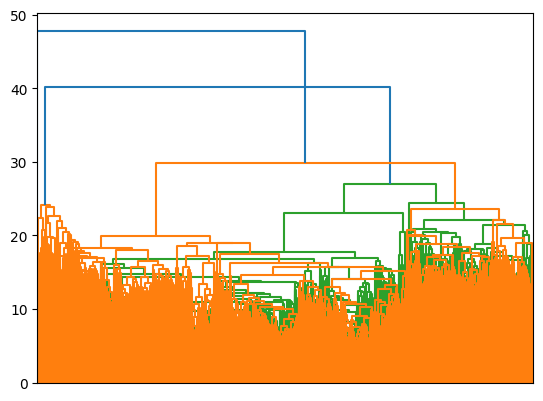

In [12]:
dn_ccm = (dendrogram(Z_ccm[0], no_labels=True), dendrogram(Z_ccm[1], no_labels=True))

In [13]:
clustered_genes = genes[dn_ccm[0]["leaves"]]
idx = np.argwhere(clustered_genes == YHP1)[0][0]
print(idx, np.argwhere(clustered_genes[idx - 30 : idx + 30] == YOX1))

981 [[4]]


In [6]:
corr = df_data.corr().to_numpy()
corr_clustered, Z_corr = cluster(corr, method="average")

NameError: name 'cluster' is not defined

In [19]:
plot_matrix(corr, "correlation.png")
plot_matrix(corr_clustered, "correlation_clustered.png")

In [15]:
rhodiff = ccm - corr
rhodiff_clustered, Z_rhodiff = cluster(rhodiff, method="average")

In [21]:
plot_matrix(rhodiff, "rhodiff.png")
plot_matrix(rhodiff_clustered, "rhodiff_clustered.png")

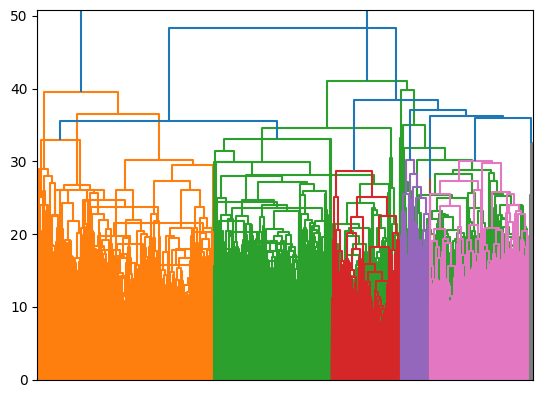

In [ ]:
dn_rhodiff = (
    dendrogram(Z_rhodiff[0], no_labels=True),
    dendrogram(Z_rhodiff[1], no_labels=True),
)

In [23]:
clustered_genes = genes[dn_rhodiff[0]["leaves"]]
print(
    f"YOX1: {np.argwhere(clustered_genes == YOX1)[0][0]}, YHP1: {np.argwhere(clustered_genes == YHP1)[0][0]}, CLN3: {np.argwhere(clustered_genes == CLN3)[0][0]}"
)
print(
    f"Best1: {np.argwhere(clustered_genes == 'YKL172W')[0][0]}, Best2: {np.argwhere(clustered_genes == 'YBR005W')[0][0]}"
)

YOX1: 922, YHP1: 1118, CLN3: 4128
Best1: 1733, Best2: 2278


In [24]:
clustered_genes = genes[dn_rhodiff[1]["leaves"]]
print(
    f"YOX1: {np.argwhere(clustered_genes == YOX1)[0][0]}, YHP1: {np.argwhere(clustered_genes == YHP1)[0][0]}, CLN3: {np.argwhere(clustered_genes == CLN3)[0][0]}"
)
print(
    f"Best1: {np.argwhere(clustered_genes == 'YKL172W')[0][0]}, Best2: {np.argwhere(clustered_genes == 'YBR005W')[0][0]}"
)

YOX1: 4732, YHP1: 3642, CLN3: 135
Best1: 3929, Best2: 58


In [11]:
def collect_leaves(node):
    if node.is_leaf():
        return [node.id]
    else:
        return collect_leaves(node.left) + collect_leaves(node.right)


def find_lowest_common_ancestor(Z: np.ndarray, target_leaves: np.ndarray):
    tree: ClusterNode
    nodelist: list[ClusterNode]
    tree, nodelist = to_tree(Z, rd=True)  # type: ignore

    paths = {}

    def traverse(node, path):
        if node.is_leaf():
            paths[node.id] = path
        else:
            traverse(node.left, path + [node.id])
            traverse(node.right, path + [node.id])

    traverse(tree, [])

    leaf_paths = [paths[leaf] for leaf in target_leaves]

    shortest_common_path = reduce(
        lambda x, y: [a for a, b in zip(x, y) if a == b], leaf_paths
    )

    lca_id = shortest_common_path[-1]
    lca = next((node for node in nodelist if node.id == lca_id), None)

    if lca is None:
        raise ValueError("No lowest common ancestor found")

    return lca, paths, np.array(collect_leaves(lca), dtype=np.int32)

In [103]:
target_gene_indecies = np.array(
    [
        np.argwhere(genes == YOX1).squeeze(),
        np.argwhere(genes == YHP1).squeeze(),
        np.argwhere(genes == CLN3).squeeze(),
    ]
)
print(target_gene_indecies)

[3924 1310   66]


[3924 1310   66]


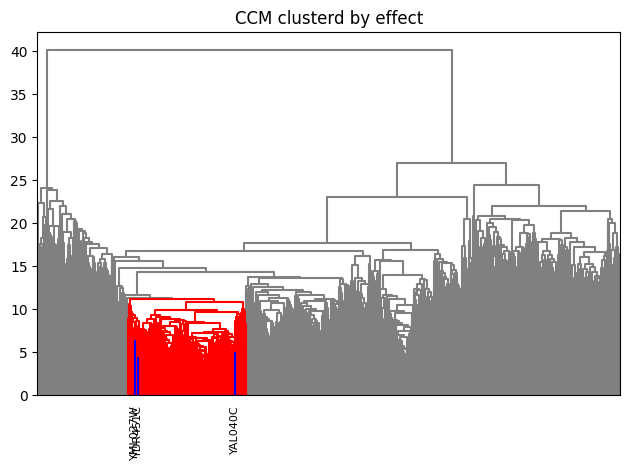

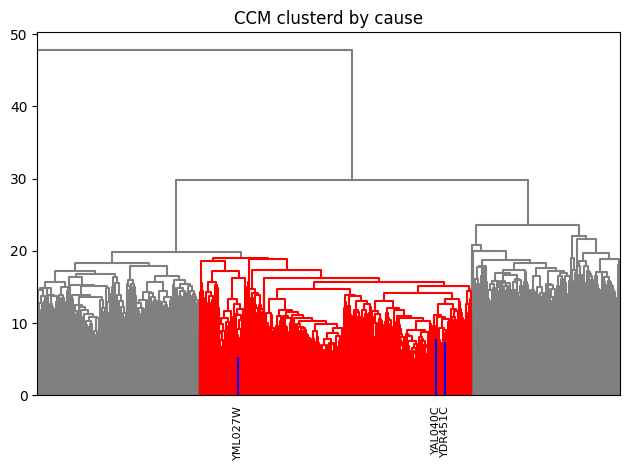

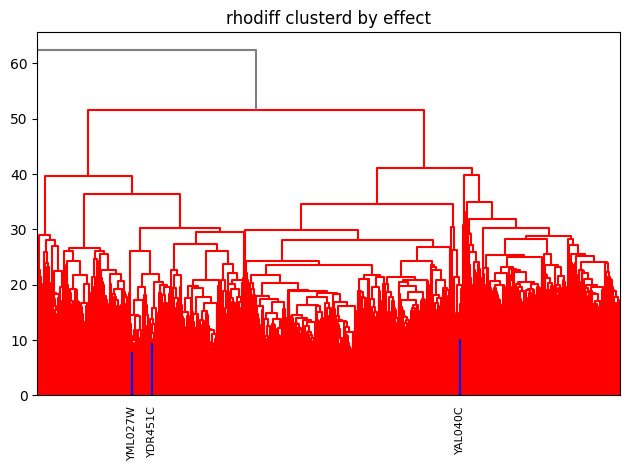

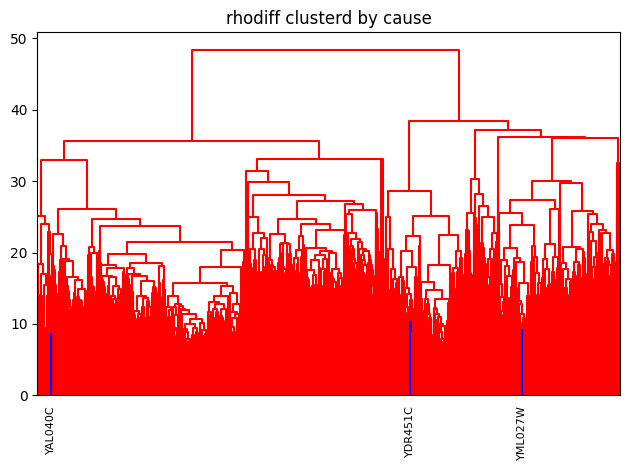

<Figure size 640x480 with 0 Axes>

In [17]:
def create_link_color_func(
    target_gene_indecies: np.ndarray,
    lca: ClusterNode,
    paths: dict[int, list[int]],
    leaves: np.ndarray,
):
    target_nodes = set()
    subtree_nodes = set()

    for leaf in leaves:
        path = np.array(paths[leaf])
        if leaf in target_gene_indecies:
            target_nodes.add(path[-1])
        subtree_nodes.update(path[path < lca.id])

    subtree_nodes.add(lca.id)

    def link_color_func(i):
        if i in target_nodes:
            return "blue"
        if i in subtree_nodes:
            return "red"
        return "gray"

    return link_color_func


def create_leaf_label_func(target_gene_indecies: np.ndarray):
    def leaf_label_func(i):
        if i in target_gene_indecies:
            return genes[i]
        return None

    return leaf_label_func


for Z, src in [(Z_ccm, "CCM"), (Z_rhodiff, "rhodiff")]:
    for i, by in [(0, "upstream"), (1, "downstream")]:
        lca, paths, leaves = find_lowest_common_ancestor(
            Z[i],
            target_gene_indecies,
        )
        dn = dendrogram(
            Z[i],
            # no_labels=True,
            link_color_func=create_link_color_func(
                target_gene_indecies, lca, paths, leaves
            ),
            leaf_label_func=create_leaf_label_func(target_gene_indecies),
            leaf_rotation=90,
            leaf_font_size=8,
        )
        plt.title(f"{src} clusterd by {by}")
        plt.tight_layout()
        plt.savefig(f"dendrogram_{src}_{by}.png", dpi=300)
        plt.clf()

In [82]:
lca, paths, leaves = find_lowest_common_ancestor(
    Z_ccm[0],
    target_gene_indecies,
)
np.argwhere(leaves == np.argwhere(genes == CLN3).squeeze())

array([[1041]])

In [17]:
gene_group = ccm[leaves][:, leaves]
gene_group.shape

(1146, 1146)

In [86]:
fit = umap.UMAP(n_neighbors=3)
embedding: np.ndarray = fit.fit_transform(gene_group)  # type: ignore

layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding[:, 0],
        y=embedding[:, 1],
        mode="markers",
        marker=dict(color="blue"),
        text=[genes[i] for i in leaves],
        hoverinfo="text",
    )
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [98]:
DEPOT = np.argwhere(leaves == np.argwhere(genes == CLN3).squeeze()).squeeze() + 1
DEPOT

np.int64(1042)

In [51]:
def save_NODE_COORD_SECTION(arr: np.ndarray, filename: str):
    with open(filename, "w") as f:
        for i, (x, y) in enumerate(arr):
            f.write(f"{i + 1} {x} {y}\n")


save_NODE_COORD_SECTION(embedding, "NODE_COORD_SECTION.txt")

In [20]:
def save_EDGE_WEIGHT_SECTION(arr: np.ndarray, filename: str):
    arr = 1 - arr
    arr = arr * 10000
    arr = arr.astype(np.int32)
    with open(filename, "w") as f:
        for row in arr:
            f.write(" ".join(map(str, row)) + "\n")


save_EDGE_WEIGHT_SECTION(gene_group, "EDGE_WEIGHT_SECTION.txt")

In [49]:
with open("./LKH-3.0.10/gene.tour", "r") as f:
    for line in f:
        if line.startswith("TOUR_SECTION"):
            break
    tour = np.array([int(line) - 1 for line in f.readlines()[:-2]])


layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding[:, 0],
        y=embedding[:, 1],
        mode="markers",
        marker=dict(color="blue"),
        text=[genes[leaves][i] for i in leaves],
        hoverinfo="text",
    ),
    go.Scatter(
        x=embedding[tour, 0],
        y=embedding[tour, 1],
        mode="lines+markers",
        line=dict(color="red"),
        marker=dict(size=10, symbol="arrow", angleref="previous"),
    ),
]

fig = go.Figure(data=data, layout=layout)

fig.show()

In [116]:
with open("./LKH-3.0.10/umap.tour", "r") as f:
    for line in f:
        if line.startswith("TOUR_SECTION"):
            break
    tour = np.array([int(line) - 1 for line in f.readlines()[:-2]])


layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding[tour, 0],
        y=embedding[tour, 1],
        mode="lines+markers",
        line=dict(color="red"),
        marker=dict(size=10, symbol="arrow", angleref="previous"),
        hoverinfo="skip",
        showlegend=False,
    ),
    go.Scatter(
        x=embedding[:, 0],
        y=embedding[:, 1],
        mode="markers",
        marker=dict(
            color=[
                "green"
                if i == tour[0]
                else "black"
                if i == tour[-1]
                else "yellow"
                if i in target_gene_indecies
                else "blue"
                for i in range(len(leaves))
            ],
            size=[
                10 if i == tour[0] or i == tour[-1] or i in target_gene_indecies else 6
                for i in range(len(leaves))
            ],
        ),
        text=[genes[i] for i in leaves],
        showlegend=False,
        hoverinfo="text",
    ),
]

fig = go.Figure(data=data, layout=layout)

fig.show()

In [113]:
signaling_pathway = genes[leaves[tour]]
signaling_pathway[:10]

array(['YAL040C', 'YIL147C', 'YOR016C', 'YNR028W', 'YJL157C', 'YGL093W',
       'YER170W', 'YEL047C', 'YML109W', 'YBR202W'], dtype='<U9')

In [ ]:
fit = umap.UMAP(n_neighbors=3)
embedding: np.ndarray = fit.fit_transform(gene_group)  # type: ignore

layout = go.Layout(
    title="UMAP of CCM genes",
    xaxis=dict(title="UMAP1"),
    yaxis=dict(title="UMAP2"),
    width=800,
    height=800,
)

data = [
    go.Scatter(
        x=embedding[:, 0],
        y=embedding[:, 1],
        mode="markers",
        marker=dict(color="blue"),
        text=[genes[i] for i in leaves],
        hoverinfo="text",
    )
]

fig = go.Figure(data=data, layout=layout)
fig.show()

In [25]:
def find_groups(corr_matrix: np.ndarray, threshold: float = 0.9) -> list[set[int]]:
    n = corr_matrix.shape[0]
    unassigned = set(range(n))
    groups = []

    with tqdm(total=n, desc="Finding groups") as pbar:
        while unassigned:
            current = unassigned.pop()
            group = {current}
            candidates = (
                set(np.where(corr_matrix[current] >= threshold)[0]) & unassigned
            )

            while candidates:
                best_candidate = max(
                    candidates,
                    key=lambda x: sum(corr_matrix[x, list(group)] >= threshold),
                )
                if sum(corr_matrix[best_candidate, list(group)] >= threshold) == len(
                    group
                ):
                    group.add(best_candidate)
                    unassigned.remove(best_candidate)
                    candidates = (
                        candidates
                        & set(np.where(corr_matrix[best_candidate] >= threshold)[0])
                        & unassigned
                    )
                else:
                    break

            groups.append(group)
            pbar.update(len(group))

    return groups


def assign_to_best_group(
    element: int, groups: list[set[int]], corr_matrix: np.ndarray
) -> int:
    best_group = -1
    best_sum = -float("inf")
    for i, group in enumerate(groups):
        corr_sum = sum(corr_matrix[element, j] for j in group)
        if corr_sum > best_sum:
            best_sum = corr_sum
            best_group = i
    return best_group


def optimize_groups(
    groups: list[set[int]], corr_matrix: np.ndarray, threshold: float
) -> list[set[int]]:
    total_elements = sum(len(group) for group in groups)
    with tqdm(total=total_elements, desc="Optimizing groups") as pbar:
        changed = True
        while changed:
            changed = False
            for group in groups:
                for element in list(group):
                    other_groups = [g for g in groups if g != group]
                    best_group_index = assign_to_best_group(
                        element, other_groups, corr_matrix
                    )
                    if best_group_index != -1:
                        best_group = other_groups[best_group_index]
                        if all(
                            corr_matrix[element, j] >= threshold for j in best_group
                        ):
                            group.remove(element)
                            best_group.add(element)
                            changed = True
                    pbar.update(1)
            if not changed:
                pbar.update(total_elements - pbar.n)

    return [g for g in groups if g]

In [26]:
initial_groups = find_groups(corr, 0.9)
print("Initial groups:", len(initial_groups))
optimized_groups = optimize_groups([set(group) for group in initial_groups], corr, 0.9)
sizes = [len(group) for group in optimized_groups]
min_size, max_size = min(sizes), max(sizes)
print(len(optimized_groups), min_size, max_size, sizes)

Finding groups: 100%|██████████| 5690/5690 [00:00<00:00, 8593.81it/s] 


Initial groups: 4594


Optimizing groups: 161654it [15:29, 173.97it/s]                        


KeyboardInterrupt: 

In [31]:
def filter_redundunt_factors(
    corr_matrix: np.ndarray, threshold: float
) -> tuple[np.ndarray, np.ndarray]:
    n = corr_matrix.shape[0]
    mask = np.ones(n, dtype=bool)
    np.fill_diagonal(corr_matrix, 0)

    for i in tqdm(range(n), desc="Filtering redundant factors"):
        if mask[i]:
            mask = (corr_matrix[i] < threshold) & mask

    filtered_corr = corr_matrix[mask][:, mask]
    return filtered_corr, np.where(~mask)[0]


filtered_corr, redundunt_factors = filter_redundunt_factors(corr, 0.9)

Filtering redundant factors:  23%|██▎       | 1307/5690 [00:00<00:00, 13033.10it/s]

Filtering redundant factors: 100%|██████████| 5690/5690 [00:00<00:00, 8098.69it/s] 


In [34]:
print(len(filtered_corr), len(redundunt_factors), redundunt_factors)

4389 1301 [   1    5    6 ... 5680 5682 5683]
